In [67]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yfin
import scipy.optimize as sc
import plotly.graph_objects as go
import matplotlib.pyplot as plt
yfin.pdr_override()

In [68]:
def getData(stocks,start,end):
    stockData = pdr.get_data_yahoo(stocks, start = start, end = end)
    stockData = stockData["Close"]
    
    return stockData.pct_change()
    

In [87]:
stock_list = ("AAPL","AMZN","GOOGL","META") ## INPUT DEESIRED STOCKS IN PORTFOLIO
endDate = dt.datetime.now() ## GET REQUIRED DATE RANGE
startDate = endDate - dt.timedelta(days = 365)

In [88]:
pctChange = getData(stock_list,startDate, endDate)

## MEAN PERCENT CHANGE = MEAN OF RETURNS
mean_returns = pctChange.mean()

## COVARIANCE OF PERCENT CHANGE ACROSS STOCKS IN PORTFOLIO
cov_matrix = pctChange.cov()


[*********************100%***********************]  4 of 4 completed


In [89]:
def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)*252
    std = np.sqrt(
            np.dot(weights.T,np.dot(covMatrix, weights))
           )*np.sqrt(252)
    return returns, std

# GENERATING PORTFOLIOS WITH RANDOMIZED WEIGHTS

In [90]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stock_list)) 
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolioPerformance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

# GRAPHING 2500 PORTFOLIOS

In [91]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(25000,mean_returns, cov_matrix, 0.0178)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index= pctChange.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index= pctChange.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.42
Annualised Volatility: 0.1


            AAPL   AMZN  GOOGL  META
allocation  2.78  92.47   3.99  0.75
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.42
Annualised Volatility: 0.1


            AAPL   AMZN  GOOGL  META
allocation  2.78  92.47   3.99  0.75


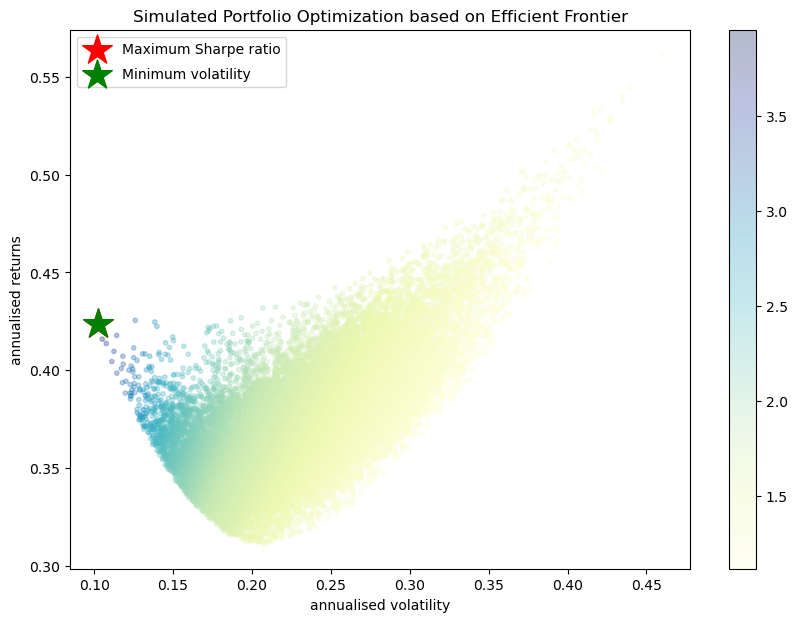

In [92]:
display_simulated_ef_with_random(mean_returns, cov_matrix, 25000, 0.0178)

# FINDING AND MAXIMIZING SHARPE RATIO

In [93]:
def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - (pReturns - riskFreeRate)/pStd
def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet=(0.0,1.0)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(negativeSR, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# FINDING AND MINIMIZING PORTFOLIO VARIANCE

In [94]:
def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]
def minimizeVariance(meanReturns, covMatrix, constraintSet=(0,1)):
    """Minimize the portfolio variance by altering the 
     weights/allocation of assets in the portfolio"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# CREATING EFFICIENT FRONTIER

In [95]:
def portfolioReturn(weights, meanReturns, covMatrix):
        return portfolioPerformance(weights, meanReturns, covMatrix)[0]
def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet=(0,1)):
    """For each returnTarget, we want to optimise the portfolio for min variance"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq', 'fun': lambda x: portfolioReturn(x, meanReturns, covMatrix) - returnTarget},
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    effOpt = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return effOpt

In [96]:
def calculatedResults(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Sharpe Ratio Portfolio
    maxSR_Portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_Portfolio['x'], meanReturns, covMatrix)
    maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    maxSR_allocation = pd.DataFrame(maxSR_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    maxSR_allocation.allocation = [round(i*100,0) for i in maxSR_allocation.allocation]
    
    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_Portfolio['x'], meanReturns, covMatrix)
    minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]
    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target)['fun'])
    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList,targetReturns

# VISUALISING FRONTIER

In [97]:
def EF_graph(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """Return a graph ploting the min vol, max sr and efficient frontier"""
    maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns = calculatedResults(meanReturns, covMatrix, riskFreeRate, constraintSet)
    #Max SR
    MaxSharpeRatio = go.Scatter(
        name='Maximium Sharpe Ratio',
        mode='markers',
        x=[maxSR_std],
        y=[maxSR_returns],
        marker=dict(color='red',size=14,line=dict(width=3, color='black'))
    )
    #Min Vol
    MinVol = go.Scatter(
        name='Mininium Volatility',
        mode='markers',
        x=[minVol_std],
        y=[minVol_returns],
        marker=dict(color='green',size=14,line=dict(width=3, color='black'))
    )
    #Efficient Frontier
    EF_curve = go.Scatter(
        name='Efficient Frontier',
        mode='lines',
        x=[round(ef_std*100, 2) for ef_std in efficientList],
        y=[round(target*100, 2) for target in targetReturns],
        line=dict(color='black', width=4, dash='dashdot')
    )
    data = [MaxSharpeRatio, MinVol, EF_curve]
    layout = go.Layout(
        title = 'Portfolio Optimisation with the Efficient Frontier',
        yaxis = dict(title='Annualised Return (%)'),
        xaxis = dict(title='Annualised Volatility (%)'),
        showlegend = True,
        legend = dict(
            x = 0.75, y = 0, traceorder='normal',
            bgcolor='#E2E2E2',
            bordercolor='black',
            borderwidth=2),
        width=800,
        height=600)
    
    fig = go.Figure(data=data, layout=layout)
    return fig.show()

In [98]:
EF_graph(mean_returns, cov_matrix)

In [ ]:
#single cell



import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yfin
import scipy.optimize as sc
import plotly.graph_objects as go
import matplotlib.pyplot as plt
yfin.pdr_override()

def getData(stocks,start,end):
    stockData = pdr.get_data_yahoo(stocks, start = start, end = end)
    stockData = stockData["Close"]
    
    return stockData.pct_change()

stock_list = ("AAPL","AMZN","GOOGL","META") ## INPUT DEESIRED STOCKS IN PORTFOLIO
endDate = dt.datetime.now() ## GET REQUIRED DATE RANGE
startDate = endDate - dt.timedelta(days = 365)

pctChange = getData(stock_list,startDate, endDate)

## MEAN PERCENT CHANGE = MEAN OF RETURNS
mean_returns = pctChange.mean()

## COVARIANCE OF PERCENT CHANGE ACROSS STOCKS IN PORTFOLIO
cov_matrix = pctChange.cov()

def portfolioPerformance(weights, meanReturns, covMatrix):
    returns = np.sum(meanReturns*weights)*252
    std = np.sqrt(
            np.dot(weights.T,np.dot(covMatrix, weights))
           )*np.sqrt(252)
    return returns, std



def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(stock_list)) 
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolioPerformance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(25000,mean_returns, cov_matrix, 0.0178)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index= pctChange.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index= pctChange.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    #show the above plot in streamlit


st.write(display_simulated_ef_with_random(mean_returns, cov_matrix, 25000, 0.0178))




def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
    pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
    return - (pReturns - riskFreeRate)/pStd
def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet=(0.0,1.0)):
    "Minimize the negative SR, by altering the weights of the portfolio"
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix, riskFreeRate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(negativeSR, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result



def portfolioVariance(weights, meanReturns, covMatrix):
    return portfolioPerformance(weights, meanReturns, covMatrix)[1]
def minimizeVariance(meanReturns, covMatrix, constraintSet=(0,1)):
    """Minimize the portfolio variance by altering the 
     weights/allocation of assets in the portfolio"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    result = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def portfolioReturn(weights, meanReturns, covMatrix):
        return portfolioPerformance(weights, meanReturns, covMatrix)[0]
def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet=(0,1)):
    """For each returnTarget, we want to optimise the portfolio for min variance"""
    numAssets = len(meanReturns)
    args = (meanReturns, covMatrix)
    constraints = ({'type':'eq', 'fun': lambda x: portfolioReturn(x, meanReturns, covMatrix) - returnTarget},
                    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = constraintSet
    bounds = tuple(bound for asset in range(numAssets))
    effOpt = sc.minimize(portfolioVariance, numAssets*[1./numAssets], args=args, method = 'SLSQP', bounds=bounds, constraints=constraints)
    return effOpt


def calculatedResults(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """Read in mean, cov matrix, and other financial information
        Output, Max SR , Min Volatility, efficient frontier """
    # Max Sharpe Ratio Portfolio
    maxSR_Portfolio = maxSR(meanReturns, covMatrix)
    maxSR_returns, maxSR_std = portfolioPerformance(maxSR_Portfolio['x'], meanReturns, covMatrix)
    maxSR_returns, maxSR_std = round(maxSR_returns*100,2), round(maxSR_std*100,2)
    maxSR_allocation = pd.DataFrame(maxSR_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    maxSR_allocation.allocation = [round(i*100,0) for i in maxSR_allocation.allocation]
    
    # Min Volatility Portfolio
    minVol_Portfolio = minimizeVariance(meanReturns, covMatrix)
    minVol_returns, minVol_std = portfolioPerformance(minVol_Portfolio['x'], meanReturns, covMatrix)
    minVol_returns, minVol_std = round(minVol_returns*100,2), round(minVol_std*100,2)
    minVol_allocation = pd.DataFrame(minVol_Portfolio['x'], index=meanReturns.index, columns=['allocation'])
    minVol_allocation.allocation = [round(i*100,0) for i in minVol_allocation.allocation]
    # Efficient Frontier
    efficientList = []
    targetReturns = np.linspace(minVol_returns, maxSR_returns, 20)
    for target in targetReturns:
        efficientList.append(efficientOpt(meanReturns, covMatrix, target)['fun'])
    return maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList,targetReturns

def EF_graph(meanReturns, covMatrix, riskFreeRate=0, constraintSet=(0,1)):
    """Return a graph ploting the min vol, max sr and efficient frontier"""
    maxSR_returns, maxSR_std, maxSR_allocation, minVol_returns, minVol_std, minVol_allocation, efficientList, targetReturns = calculatedResults(meanReturns, covMatrix, riskFreeRate, constraintSet)
    #Max SR
    MaxSharpeRatio = go.Scatter(
        name='Maximium Sharpe Ratio',
        mode='markers',
        x=[maxSR_std],
        y=[maxSR_returns],
        marker=dict(color='red',size=14,line=dict(width=3, color='black'))
    )
    #Min Vol
    MinVol = go.Scatter(
        name='Mininium Volatility',
        mode='markers',
        x=[minVol_std],
        y=[minVol_returns],
        marker=dict(color='green',size=14,line=dict(width=3, color='black'))
    )
    #Efficient Frontier
    EF_curve = go.Scatter(
        name='Efficient Frontier',
        mode='lines',
        x=[round(ef_std*100, 2) for ef_std in efficientList],
        y=[round(target*100, 2) for target in targetReturns],
        line=dict(color='black', width=4, dash='dashdot')
    )
    data = [MaxSharpeRatio, MinVol, EF_curve]
    layout = go.Layout(
        title = 'Portfolio Optimisation with the Efficient Frontier',
        yaxis = dict(title='Annualised Return (%)'),
        xaxis = dict(title='Annualised Volatility (%)'),
        showlegend = True,
        legend = dict(
            x = 0.75, y = 0, traceorder='normal',
            bgcolor='#E2E2E2',
            bordercolor='black',
            borderwidth=2),
        width=800,
        height=600)
    
    fig = go.Figure(data=data, layout=layout)
    return fig.show()


# show in streamlit
EF_graph(mean_returns, cov_matrix)